# HomeBrew Analysis

# Problem Statement
The data that has been provided contains submissions of beer recipes from Brewer's Friend. Some of the information contained are: Beer Name, Beer Style, Original Gravity, Brew Method, etc.

Based off of what has been provided, I would be interested to see if one can predict the "Style of Beer".

# Intitial Setup

## Clear Environment

In [1]:
rm(list = ls())

## Load Libraries

In [2]:
library(dplyr) # data manipulation
library(tidyr) # data manipulation
library(ggplot2) # data viz
library(corrplot) # visualize correlation matrices
library(purrr) # mapping over arrays
library(caret) # 1 stop shop for ML libraries, ML functionalities, and ML controls
library(rpart) # Decision Tree
library(rpart.plot) # Visualize Decision Trees
library(e1071) # SVM and Naive-Bayes
library(class) # K-Nearest-Neighbors
library(randomForest) # Random Fores
library(broom) # Performing ML on grouped data sets
library(infer) # Performing inferential statistics
library(onehot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

corrplot 0.84 loaded
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



## Read in Data

In [3]:
setwd(getwd())

dataFiles = grep(".csv", list.files(), value = T)
# Output are 2 files from the original .zip, recipeData.csv & styleData.csv

recipe = read.csv(dataFiles[1]) # grap recipe Data

# Intitial View

Let's view the data in a few different ways to get a good overall understanding of what it is we are working with.
When I first started getting into data, I would often skip this part, but now it has become a mandatory step for me as it has literally saved me HOURS worth of downstream troubleshooting by recognizing anomalies and irregularities up front.
You have probably heard many times before that Data Cleaning is ~75% of the process, I would add that it is probably also the most revisited part of the process too.

In [4]:
head(recipe)

BeerID,Name,URL,Style,StyleID,Size.L.,OG,FG,ABV,IBU,⋯,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,⋯,75,1.038,70,N/A,Specific Gravity,All Grain,N/A,17.78,corn sugar,4.5 oz
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumking-clone,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,⋯,60,1.07,70,N/A,Specific Gravity,All Grain,N/A,N/A,N/A,N/A
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-extract,American IPA,7,18.93,1.063,1.018,5.91,59.25,⋯,60,N/A,70,N/A,Specific Gravity,extract,N/A,N/A,N/A,N/A
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-all-grain,American IPA,7,22.71,1.061,1.017,5.80,54.48,⋯,60,N/A,70,N/A,Specific Gravity,All Grain,N/A,N/A,N/A,N/A
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgisk-blonde-50-l,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,⋯,90,1.05,72,N/A,Specific Gravity,All Grain,N/A,19,Sukkerlake,6-7 g sukker/l
6,Sierra Nevada Pale Ale Clone,/homebrew/recipe/view/28546/sierra-nevada-pale-ale-clone,American Pale Ale,10,24.61,1.055,1.013,5.58,40.12,⋯,70,1.047,79,N/A,Specific Gravity,All Grain,1,N/A,N/A,N/A


In [5]:
str(recipe)

'data.frame':	73861 obs. of  22 variables:
 $ BeerID       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Name         : Factor w/ 59149 levels "?","??","?? ???",..: 55873 50089 59069 59064 6300 48068 45660 50441 14150 34321 ...
 $ URL          : Factor w/ 73861 levels "/homebrew/recipe/view/100034/double-dog-citra-ipa",..: 2457 2468 68315 68265 73416 20361 35607 72564 21628 70922 ...
 $ Style        : Factor w/ 176 levels "Altbier","Alternative Grain Beer",..: 45 85 7 7 20 10 86 45 129 86 ...
 $ StyleID      : int  45 85 7 7 20 10 86 45 129 86 ...
 $ Size.L.      : num  21.8 20.8 18.9 22.7 50 ...
 $ OG           : num  1.05 1.08 1.06 1.06 1.06 ...
 $ FG           : num  1.01 1.02 1.02 1.02 1.01 ...
 $ ABV          : num  5.48 8.16 5.91 5.8 6.48 5.58 7.09 5.36 5.77 8.22 ...
 $ IBU          : num  17.6 60.6 59.2 54.5 17.8 ...
 $ Color        : num  4.83 15.64 8.98 8.5 4.57 ...
 $ BoilSize     : num  28.4 24.6 22.7 26.5 60 ...
 $ BoilTime     : int  75 60 60 60 90 70 90 75 75 60 ...
 $ BoilGravity  

In [6]:
glimpse(recipe)

Observations: 73,861
Variables: 22
$ BeerID        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16...
$ Name          <fct> Vanilla Cream Ale, Southern Tier Pumking clone, Zombi...
$ URL           <fct> /homebrew/recipe/view/1633/vanilla-cream-ale, /homebr...
$ Style         <fct> Cream Ale, Holiday/Winter Special Spiced Beer, Americ...
$ StyleID       <int> 45, 85, 7, 7, 20, 10, 86, 45, 129, 86, 7, 7, 7, 7, 7,...
$ Size.L.       <dbl> 21.77, 20.82, 18.93, 22.71, 50.00, 24.61, 22.71, 20.8...
$ OG            <dbl> 1.055, 1.083, 1.063, 1.061, 1.060, 1.055, 1.072, 1.05...
$ FG            <dbl> 1.013, 1.021, 1.018, 1.017, 1.010, 1.013, 1.018, 1.01...
$ ABV           <dbl> 5.48, 8.16, 5.91, 5.80, 6.48, 5.58, 7.09, 5.36, 5.77,...
$ IBU           <dbl> 17.65, 60.65, 59.25, 54.48, 17.84, 40.12, 268.71, 19....
$ Color         <dbl> 4.83, 15.64, 8.98, 8.50, 4.57, 8.00, 6.33, 5.94, 34.7...
$ BoilSize      <dbl> 28.39, 24.61, 22.71, 26.50, 60.00, 29.34, 30.28, 28.3...
$ BoilTime      <

In [7]:
summary(recipe)

     BeerID                  Name      
 Min.   :    1   Awesome Recipe: 1311  
 1st Qu.:18466   IPA           :  197  
 Median :36931   Saison        :  181  
 Mean   :36931   K\xf6lsch     :  173  
 3rd Qu.:55396   Black IPA     :  129  
 Max.   :73861   Stout         :  129  
                 (Other)       :71741  
                                                    URL       
 /homebrew/recipe/view/100034/double-dog-citra-ipa    :    1  
 /homebrew/recipe/view/10003/yuen-porter-clone        :    1  
 /homebrew/recipe/view/100068/hop-rocket              :    1  
 /homebrew/recipe/view/100096/evie-pale-ale-ag        :    1  
 /homebrew/recipe/view/100147/battle-of-flodden       :    1  
 /homebrew/recipe/view/100221/belgian-double-black-ipa:    1  
 (Other)                                              :73855  
                  Style          StyleID          Size.L.       
 American IPA        :11940   Min.   :  1.00   Min.   :   1.00  
 American Pale Ale   : 7581   1st Qu.: 10.00  

# Data Cleaning/Pre-Processing
## Fixing Data

The very first thing that jumped out to me in viewing the data above, is that there are a bunch of NAs in the data. But if you pay close attention, they aren't recognized as ACTUAL 'NA' values, instead, they are recognized as class "character" (likely due to the '/' between the 'N' and the 'A'). This is the first fix.

In [8]:
 # Change the values to actual NAs that R can understand as missing data
missingValueFill = function(x) {
  if(length(which(x == "N/A")) > 0) { # check to see if the column has any "N/A" in it
    ifelse(x == "N/A", NA, as.character(x)) # coerce to NA
    # The False condition in the ifelse above needs to be converted to a character
    # If 'x' was returned alone, then all factors would change to their integer representation (data type along with it)
  } else {
    x
  }
}

recipeNA = recipe %>%
  mutate_all(funs(missingValueFill))

# Sum up the amount of na values across variables
recipeNA %>%
  sapply(., function(x) {
    sum(is.na(x))
  })

BeerID          Name           URL         Style       StyleID 
            0             1             0           596             0 
      Size.L.            OG            FG           ABV           IBU 
            0             0             0             0             0 
        Color      BoilSize      BoilTime   BoilGravity    Efficiency 
            0             0             0          2990             0 
MashThickness    SugarScale    BrewMethod     PitchRate   PrimaryTemp 
        29864             0             0         39252         22662 
PrimingMethod PrimingAmount 
        67095         69085

## Change Data Types

Now that NAs are appearing correctly, we can fix the data types for the columns.

In [9]:
# Clean up classes
recipeClass = recipeNA %>%
  mutate_at(vars(BoilGravity, MashThickness, PrimaryTemp, PitchRate), as.numeric) %>% # Coerce to numerical data
  mutate_at(vars(Style, PrimingMethod), as.factor) %>% # coerce to categorical data
  mutate_at(vars(URL), as.character) # coerce to character

str(recipeClass)

'data.frame':	73861 obs. of  22 variables:
 $ BeerID       : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Name         : chr  "Vanilla Cream Ale" "Southern Tier Pumking clone" "Zombie Dust Clone - EXTRACT" "Zombie Dust Clone - ALL GRAIN" ...
 $ URL          : chr  "/homebrew/recipe/view/1633/vanilla-cream-ale" "/homebrew/recipe/view/16367/southern-tier-pumking-clone" "/homebrew/recipe/view/5920/zombie-dust-clone-extract" "/homebrew/recipe/view/5916/zombie-dust-clone-all-grain" ...
 $ Style        : Factor w/ 175 levels "Altbier","Alternative Grain Beer",..: 45 85 7 7 20 10 86 45 128 86 ...
 $ StyleID      : int  45 85 7 7 20 10 86 45 129 86 ...
 $ Size.L.      : num  21.8 20.8 18.9 22.7 50 ...
 $ OG           : num  1.05 1.08 1.06 1.06 1.06 ...
 $ FG           : num  1.01 1.02 1.02 1.02 1.01 ...
 $ ABV          : num  5.48 8.16 5.91 5.8 6.48 5.58 7.09 5.36 5.77 8.22 ...
 $ IBU          : num  17.6 60.6 59.2 54.5 17.8 ...
 $ Color        : num  4.83 15.64 8.98 8.5 4.57 ...
 $ BoilSize     : num  28

## Removing Unnecessary Data

Let's take a naive glance at the data and see if there are any columns that won't aid in achieving our goal of predicting Beer Style. Focusing on columns 1, 2, 3 & 5, I would assume that these don't appear to add much value. The reason being is that they all appear to be unique to the submission or redundant info. Name and URL refer to the name of the specific Beer submission (whatever the founder wanted to name it) and where on the web that submission came from. BeerID and StyleID are redundant bits of data as they are just the numerical references (indecies) of the Beer Name and Style, respectively. We've already determined that we will remove the Beer Name, and since we have the Style, StyleID becomes redundant so it can also be removed.

In [10]:
recipeRemoveCols = recipeClass %>%
  select(-BeerID, -StyleID, -Name, -URL)

str(recipeRemoveCols)

'data.frame':	73861 obs. of  18 variables:
 $ Style        : Factor w/ 175 levels "Altbier","Alternative Grain Beer",..: 45 85 7 7 20 10 86 45 128 86 ...
 $ Size.L.      : num  21.8 20.8 18.9 22.7 50 ...
 $ OG           : num  1.05 1.08 1.06 1.06 1.06 ...
 $ FG           : num  1.01 1.02 1.02 1.02 1.01 ...
 $ ABV          : num  5.48 8.16 5.91 5.8 6.48 5.58 7.09 5.36 5.77 8.22 ...
 $ IBU          : num  17.6 60.6 59.2 54.5 17.8 ...
 $ Color        : num  4.83 15.64 8.98 8.5 4.57 ...
 $ BoilSize     : num  28.4 24.6 22.7 26.5 60 ...
 $ BoilTime     : int  75 60 60 60 90 70 90 75 75 60 ...
 $ BoilGravity  : num  1.04 1.07 NA NA 1.05 ...
 $ Efficiency   : num  70 70 70 70 72 79 75 70 73 70 ...
 $ MashThickness: num  NA NA NA NA NA NA NA 1.4 NA NA ...
 $ SugarScale   : Factor w/ 2 levels "Plato","Specific Gravity": 2 2 2 2 2 2 2 2 2 2 ...
 $ BrewMethod   : Factor w/ 4 levels "All Grain","BIAB",..: 1 1 3 1 1 1 1 1 1 1 ...
 $ PitchRate    : num  NA NA NA NA NA 1 NA NA NA NA ...
 $ PrimaryTem

## Handling Missing Data
### View NAs

In an earlier call when I was converting string NAs into actual NAs, you can see that I validated it by seeing how many actual NAs were appearing in each column. Let's see what those proportions look like.

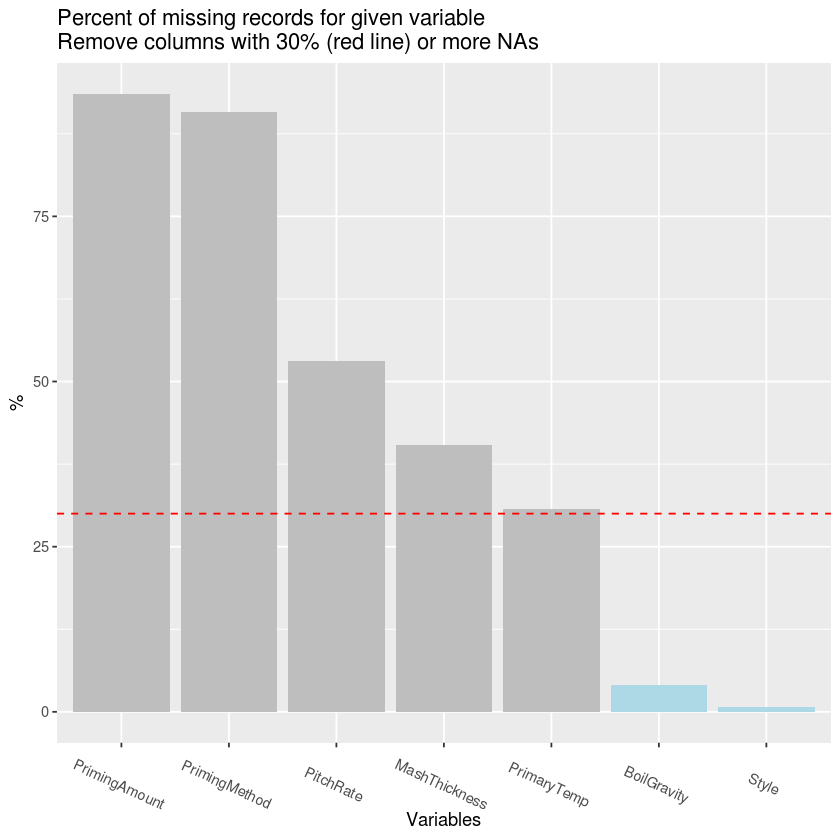

In [11]:
missingValueProp = function(x) {
  mean(is.na(x)) * 100
}

# Show only columns with NA values
proportionofNA = recipeRemoveCols %>%
  summarise_all(missingValueProp) %>%
  gather("columns", "percentNA") %>% # Gather columns into key-value pairs so I can work on them
  filter(percentNA > 0) # Return columns with missing values

proportionofNA %>%
  mutate(naCols = if_else(percentNA > 30, "gray", "lightblue")) %>% # identify what makes the cut-off
  ggplot(aes(x = reorder(columns, -percentNA), y = percentNA, fill = I(naCols))) +
  geom_bar(stat = "identity") +
  geom_hline(yintercept = 30, color = "red", linetype = 2) +
  ggtitle("Percent of missing records for given variable\nRemove columns with 30% (red line) or more NAs") +
  ylab("%") +
  xlab("Variables") +
  theme(axis.text.x = element_text(angle = -25))

I thought it would be reasonable to put a threshold at 30%. Any column with NAs beyond this threshold will get dropped. In essence, the ones in gray get dropped from the dataset.

** I think this would be an interesting place to adjust the threshold. If I moved it up to 50%, 2 more columns would get added. For now however, I'll keep it at 30% **

## What to do with NAs
As mentioned above, any columns with missing values above 30% should get dropped.

In [12]:
manyNAcols = proportionofNA$columns[which(proportionofNA$percentNA > 30)]

recipeRemoveCols = recipeRemoveCols %>%
  select(-c(which(colnames(.) %in% manyNAcols)))

colnames(recipeRemoveCols)

[1] "Style"       "Size.L."     "OG"          "FG"          "ABV"        
 [6] "IBU"         "Color"       "BoilSize"    "BoilTime"    "BoilGravity"
[11] "Efficiency"  "SugarScale"  "BrewMethod"

This still leaves the columns "Style" and "BoilGravity".
Since style is what I am trying to predict, I'm going to make another category for the missing values, "Other".

I'll need to change the column back to character class, change the NAs to "Other", then convert back to class factor. Annoying, but I haven't found a quicker way to do this yet.

In [13]:
recipeRemoveCols$Style = as.character(recipeRemoveCols$Style)
recipeRemoveCols$Style[which(is.na(recipeRemoveCols$Style))] = "Other"
recipeRemoveCols$Style = as.factor(recipeRemoveCols$Style)

Now on to Boil Gravity. Boil Gravity could potentially be a good feature in predicting Beer Style, so I'm not going to remove it. Why does it contain missing values? Well, while "OG" and "FG" (Original Gravity and Final Gravity, respectively) are measures of specific gravity before and at the completion of fermentation, Boil Gravity I believe is an intermediate check. Maybe a stage of measurement is optional in the process since the before and after measures exist. With that said, let's impute what these missing values could be. There are many different approaches to imputing, but I'm going to use a sample statistic imputation.

### Imputing w/ a sample statistic
This is one of the easier ways I have learned to impute. Essentially, it requires filling in the missing value with the statistic that best represents the central tendency of the data, i.e mean, median, or mode. Let's visualize BoilGravity and then plot all 3 statistics to see what yields a better value.

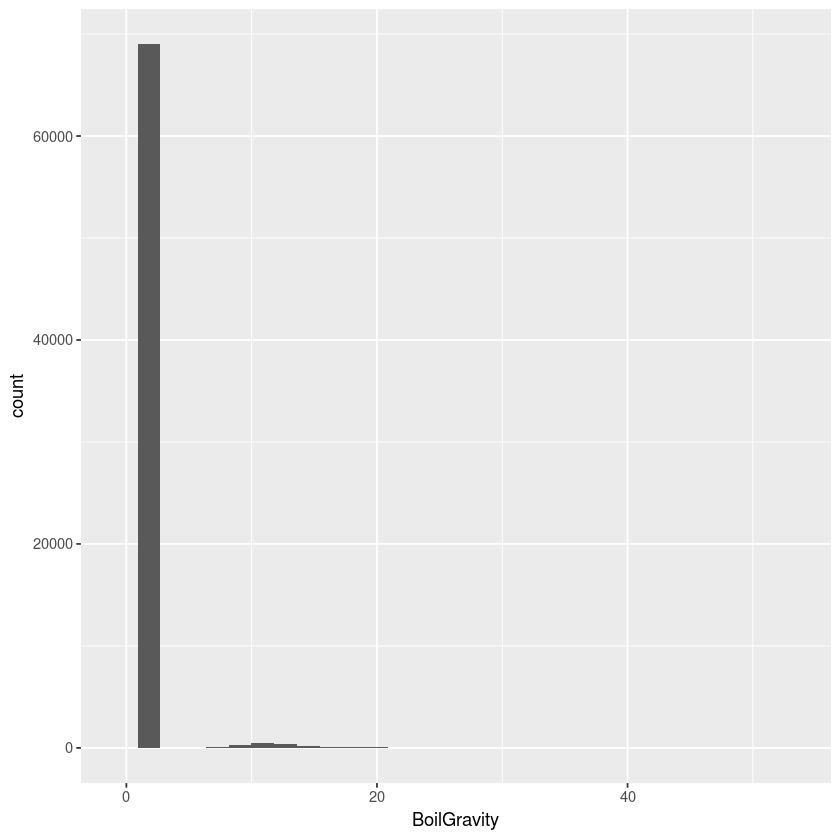

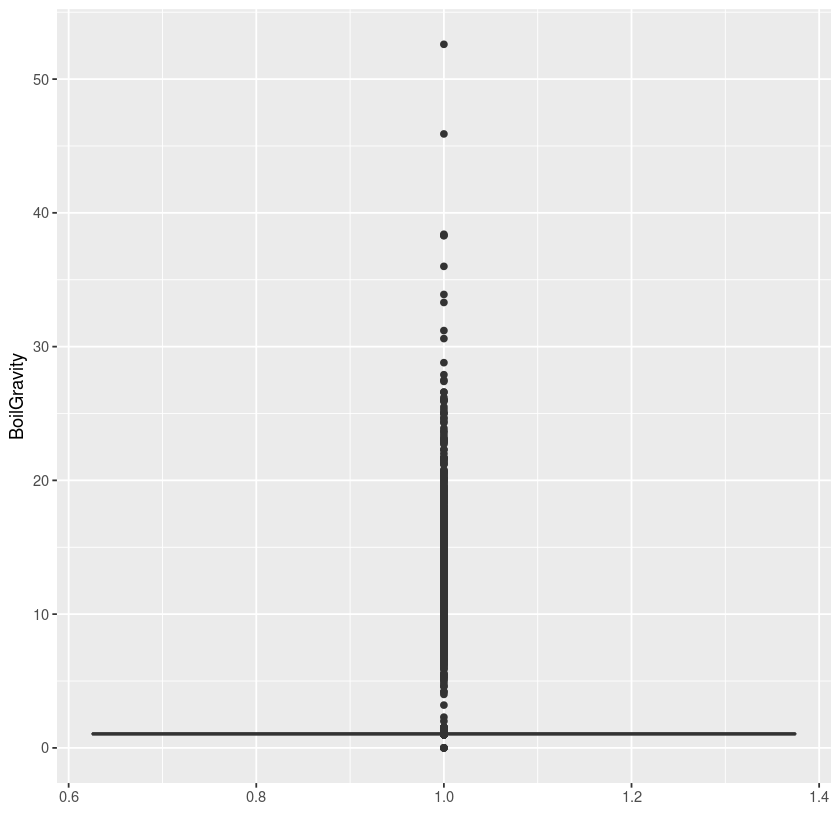

In [14]:
recipeRemoveCols %>%
    filter(!is.na(BoilGravity)) %>%
    ggplot(aes(BoilGravity)) +
    geom_histogram(bins = 30)

recipeRemoveCols %>%
    filter(!is.na(BoilGravity)) %>%
    ggplot(aes(x = 1, y = BoilGravity)) +
    geom_boxplot() +
    xlab("")


Wow. So it looks like a huge chunk of values are crowding around 1, with there being quite the large number for outliers. Why is that? If we go back to when we initially viewed the data, we can see that all the "Gravity" columns show many values that look like 1.xxx. However, the histogram above is showing us we have some data up to the 50s for Boil Gravity. 

In [15]:
# Get the range of the Gravity variables to show this wide dispersion
recipeRemoveCols %>%
    select(OG, FG, BoilGravity) %>%
    filter(!is.na(OG), !is.na(FG), !is.na(BoilGravity)) %>%
    sapply(., range)

OG,FG,BoilGravity
1.0000,-0.0030,0.0
34.0345,23.4246,52.6


After some wikipedia-ing, I see that the "SugarScale" column was screaming at me all along. Brewers can define the specific gravity of the beer as mentioned before, but some like to use what is known as the "Plato" scale. Since we are here, lets take this opportunity to convert ALL Plato values (OG and FG too) to Specifc Gravity. SG = (4P/1000) + 1

In [16]:
platoToSG = function(x) {
  (4*x/1000) + 1
}

recipeSugarScaleNest = recipeRemoveCols %>%
  nest(-SugarScale)

recipeSugarScaleNest$data[[2]] = recipeSugarScaleNest$data[[2]] %>%
  mutate_at(vars(OG, FG, BoilGravity), platoToSG)
  

recipeSG = recipeSugarScaleNest %>%
  unnest(data) %>%
  mutate(SugarScale = as.factor("Specific_Gravity"))

In [17]:
recipeSG %>%
    select(OG, FG, BoilGravity) %>%
    filter(!is.na(OG), !is.na(FG), !is.na(BoilGravity)) %>%
    sapply(., range)

OG,FG,BoilGravity
1.0,0.991,1.0
1.5,1.208,1.5


Great. Now we have all Gravity measurements converted to the Specific Gravity UoMs (units of measure).

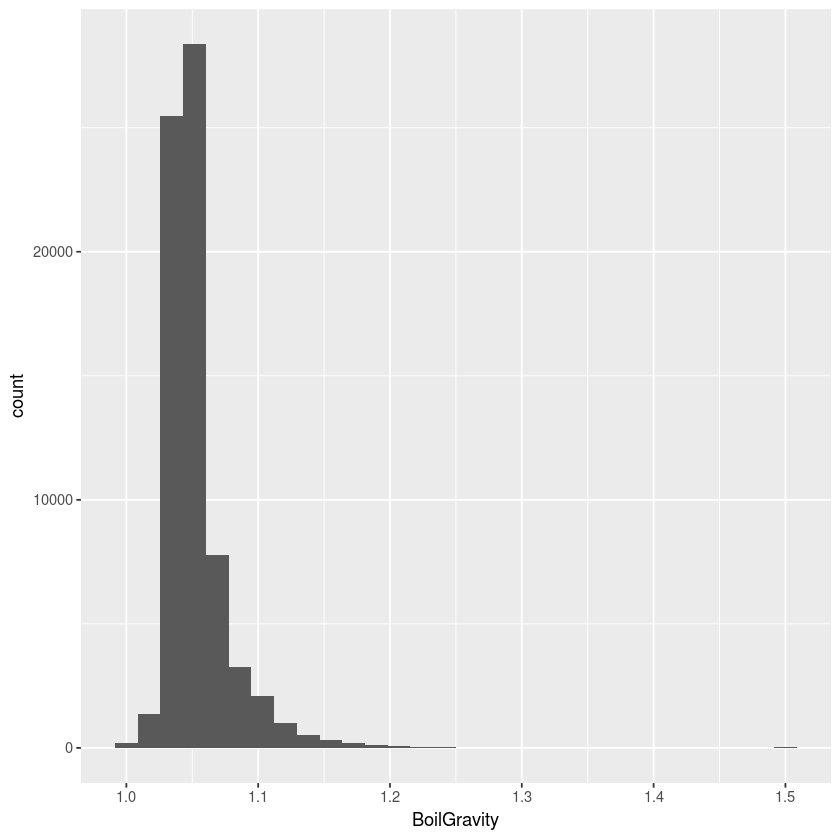

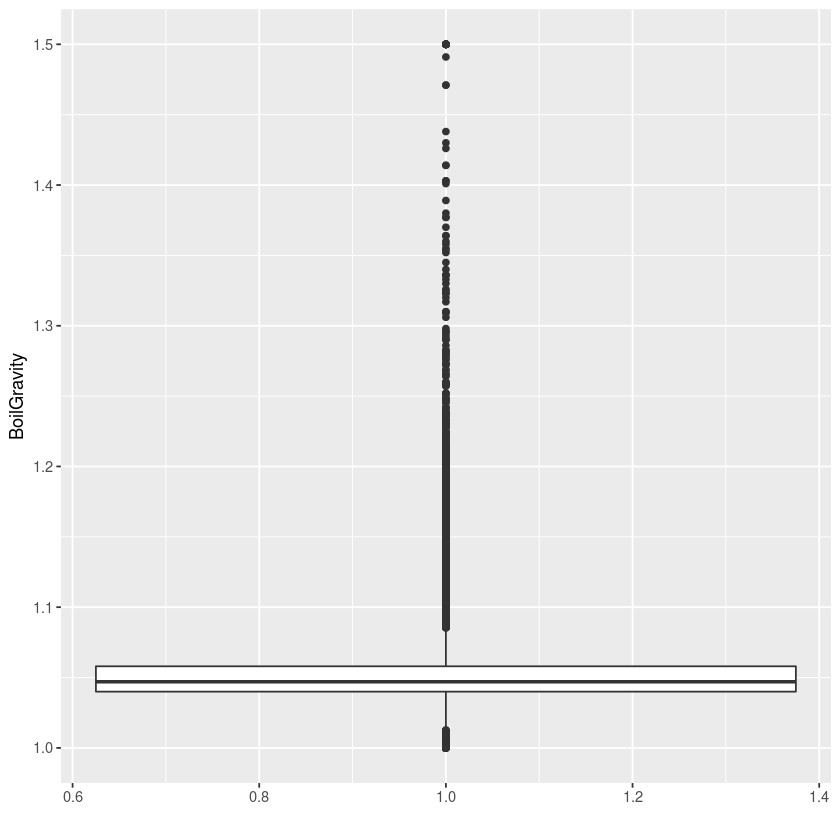

In [18]:
# Lets look at the shape and distribution of Boil Gravity again now
recipeSG %>%
    filter(!is.na(BoilGravity)) %>%
    ggplot(aes(BoilGravity)) +
    geom_histogram(bins = 30)

recipeSG %>%
    filter(!is.na(BoilGravity)) %>%
    ggplot(aes(x = 1, y = BoilGravity)) +
    geom_boxplot() +
    xlab("")

Great! Now this is a much better view of the distribution of Boil Gravity. We can describe this distribution as:
- Unimodal (1-hump)
- Right Skewed (heavy tail to the right)

We can verify there are a significant amount of outliers from the boxplot that are above the average. (Maybe some of the extreme ones are). Due to the heavy right skew from outliers, I would recommend (based off what I have learned and statistical standards) that the median be used as the best measure of central tendency for Boil Gravity. The median is less affected by outliers.

In [19]:
# Impute NA values in Boil Gravity with the median of that variable
recipeSG$BoilGravity[which(is.na(recipeSG$BoilGravity))] = median(recipeSG$BoilGravity, na.rm = T)

recipeSG %>%
    sapply(., function(x) {
        sum(is.na(x))
    })

SugarScale       Style     Size.L.          OG          FG         ABV 
          0           0           0           0           0           0 
        IBU       Color    BoilSize    BoilTime BoilGravity  Efficiency 
          0           0           0           0           0           0 
 BrewMethod 
          0

No more NAs!!

# Exploratory Data Analysis

## Dependent Variable

As mentioned in the Problem Statement, the goal is to predict the style of beer our Dependent Variable (DV). Since this is a classification problem let's see how many classes we are dealing with.

In [20]:
recipeSG$Style %>%
    levels() %>%
    length()

[1] 176

176 beer styles is alot. Let's see how these breakdown.

In [21]:
recipeSG %>%
    group_by(Style) %>%
    summarise(count = n(),
             percent = round(100*(count/nrow(recipeSG)), digits = 2)) %>%
    arrange(desc(percent)) %>%
    mutate(rolling_sum_percent = cumsum(percent)) %>%
    head(n = 10)

Style,count,percent,rolling_sum_percent
American IPA,11940,16.17,16.17
American Pale Ale,7581,10.26,26.43
Saison,2617,3.54,29.97
American Light Lager,2277,3.08,33.05
American Amber Ale,2038,2.76,35.81
Blonde Ale,1753,2.37,38.18
Imperial IPA,1478,2.00,40.18
American Stout,1268,1.72,41.90
Irish Red Ale,1204,1.63,43.53
American Brown Ale,1152,1.56,45.09


From the above, we can see that the Top 10 beer styles with the most submissions account for ~45% of the data. Let's start off with this subset to build our prediction model.

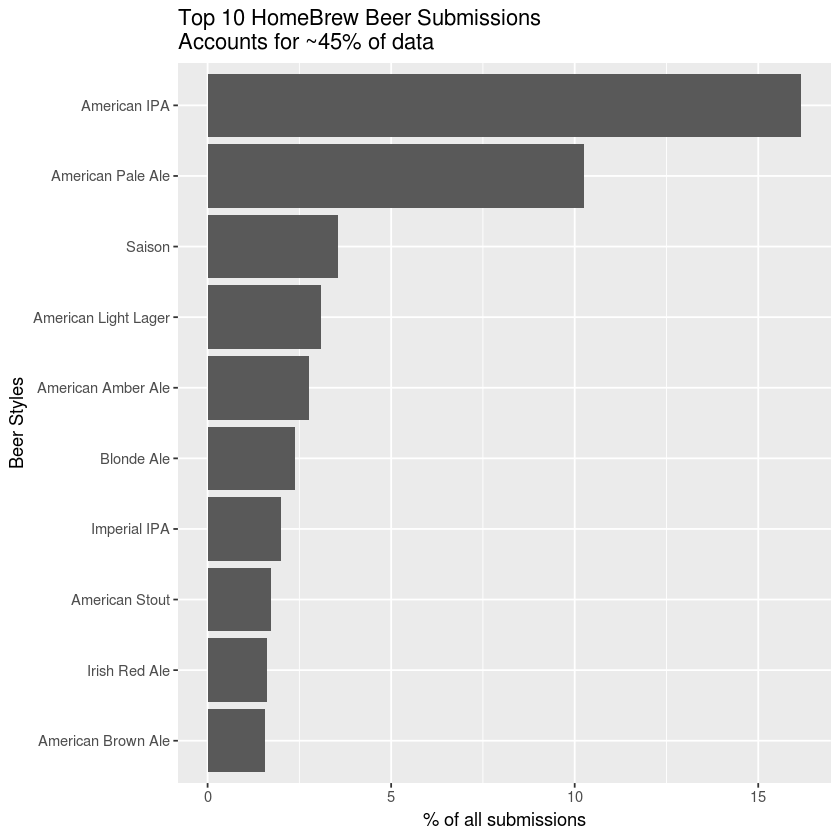

In [22]:
# Return the top ten beer styles based off number of submissions
popularBeer = recipeSG %>%
  group_by(Style) %>%
  summarise(num = n(),
            perc = round(100*(num/nrow(recipe)), digits = 2)) %>%
  top_n(10, perc)

popularBeer %>%
  ggplot(aes(x = reorder(Style, perc), y = perc)) +
  geom_bar(stat = "identity") +
  ggtitle("Top 10 HomeBrew Beer Submissions\nAccounts for ~45% of data") +
  xlab("Beer Styles") +
  ylab("% of all submissions") +
  coord_flip()

Now that I have the top 10 beers, I can go back to the original, clean data set, and filter it down for only the top 10 beers.

In [23]:
recipeTopTen = recipeSG %>%
  filter(Style %in% popularBeer$Style) %>%
  droplevels()

unique(recipeTopTen$Style)

[1] American IPA         American Pale Ale    Imperial IPA        
 [4] Saison               Blonde Ale           American Brown Ale  
 [7] American Amber Ale   American Stout       Irish Red Ale       
[10] American Light Lager
10 Levels: American Amber Ale American Brown Ale ... Saison

## Continuous Variables

### Distribution of variables

In [24]:
# Pull out all numerical/integer variables
numericFeats = recipeTopTen %>%
  select(which(sapply(., class) != "factor"))

str(numericFeats)

'data.frame':	33308 obs. of  10 variables:
 $ Size.L.    : num  18.9 22.7 24.6 22.7 20.8 ...
 $ OG         : num  1.06 1.06 1.05 1.07 1.08 ...
 $ FG         : num  1.02 1.02 1.01 1.02 1.02 ...
 $ ABV        : num  5.91 5.8 5.58 7.09 8.22 6.63 6.62 7.07 6.51 6.2 ...
 $ IBU        : num  59.2 54.5 40.1 268.7 93 ...
 $ Color      : num  8.98 8.5 8 6.33 8.29 ...
 $ BoilSize   : num  22.7 26.5 29.3 30.3 28.4 ...
 $ BoilTime   : int  60 60 70 90 60 90 90 60 60 60 ...
 $ BoilGravity: num  1.05 1.05 1.05 1.05 1.06 ...
 $ Efficiency : num  70 70 79 75 70 74 70 70 30 70 ...


Size.L.,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency
1.00,1.0,0.999,0.00,0.00,0.00,1.00,0,1.0,0
6102.08,1.5,1.156,54.72,2197.07,108.65,6454.13,240,1.5,100


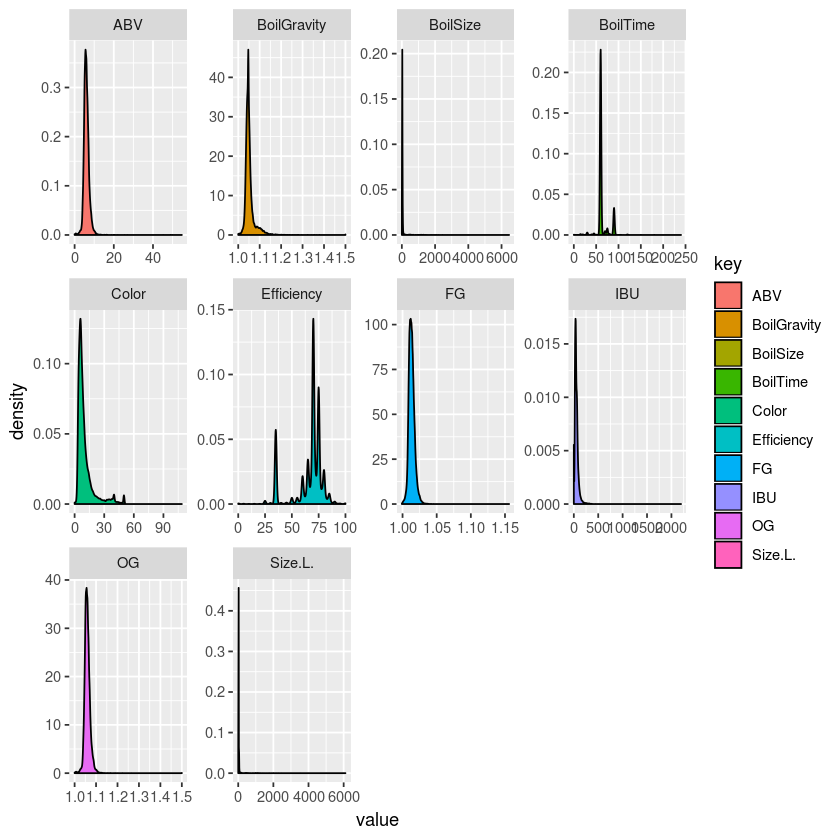

In [25]:
numericFeats %>%
    sapply(., range)

numericFeats %>%
    gather("key", "value") %>%
    ggplot(aes(x = value, fill = key)) +
    geom_density() +
    facet_wrap(~key, scales = "free")

From the table we can see that the range of values for each of the variables differs greatly. OG ranges from 0 - 1.5 while BoilSize is 0 - 6000. These variables will need to be scaled. I will keep an unscaled and a scaled version to see how they compare.

Size.L.,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency
-0.2418082,-4.251509,-3.137578,-4.229166,-1.192231,-1.183779,-0.257262,-5.270851,-2.17410,-4.666536
33.2574993,31.613367,31.231368,34.097695,47.926907,11.245373,33.036336,14.610234,18.62986,2.399406


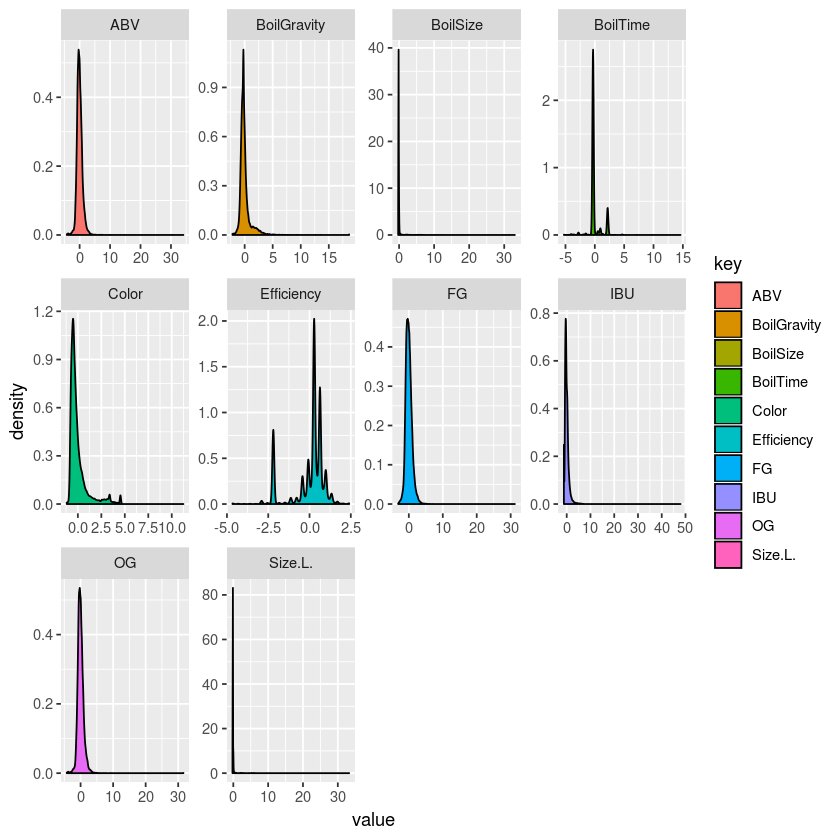

In [26]:
centerAndScale = function(x) {
    scale(x, center = T, scale = T)
}

numericFeatScaled = numericFeats %>%
    sapply(., centerAndScale) %>%
    data.frame()

numericFeatScaled %>%
    sapply(., range)

numericFeatScaled %>%
    gather("key", "value") %>%
    ggplot(aes(x = value, fill = key)) +
    geom_density() +
    facet_wrap(~key, scales = "free")

### Correlations
We have 2 tools that can help us with correlations other than:
1. Correlation Plots
    - visual representation of correlation
    - we have 10 numerical features, this will create 100 plots (10 x 10), so in order to save time and memory, I wont execute this but I will put the code for it below
    - plot(numericFeatScaled)
2. Correlation Matrix
    - another visual representation, but instead of plotting out the points on an x and y scale, the numerical value of the correlation between each pair of variables is the output

#### Correlation Matrix

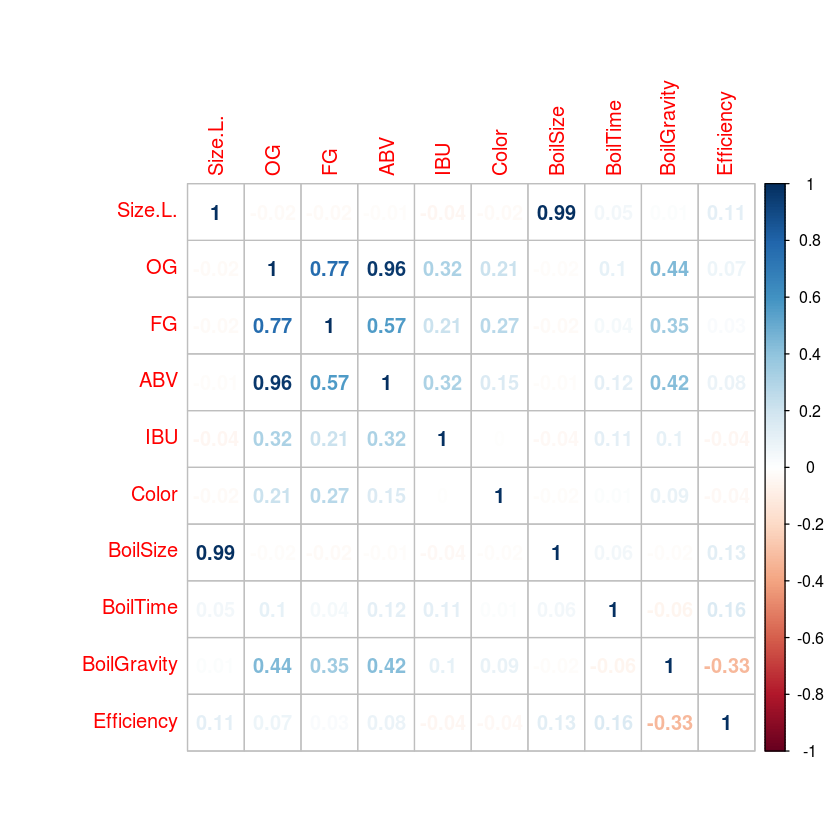

In [27]:
cor(numericFeatScaled, use = "complete.obs") %>%
    corrplot(., method = "number")

#### Collinearity

One can quickly see that there seems to be a near perfect correlation between "Size.L." and "BoilSize", which appears to be redundant information, so I will go ahead and drop the "Size.L." feature. Additionally, there seems to be a strong correlation between "OG" and "ABV" and a semi-strong one between "OG" and "FG". This may be an issue with collinearity or potential multi-collinearity, So let's investigate...

First, why is collinearity important in the first place. Well when trying to predict a DV based on 2 or more IVs, we often assume indendence amongst those IVs. In other words, we assume the IVs have no affect on each other, however, this is rarely the case. Our goal is to see how much variance in our DV can be explained by our IVs, but if we have IVs that are strongly explaining other IVs, then this will inflate the variance between the DV and all IVs, which we don't want.

I am aware of 2 different measures to check for this. Tolerance & Variance Inflation Factor (VIF). After regressing one IV on 1 or more other IVs:

1. Tolerance is the amount of variation in an independent variable that is not explained by the variance in the other independent variables. So while R2 is the measure of variation that IS explained by the predictors, tolerance would simply be "1 - R2". Larger values of Tolerance are desirable. Values less than 0.10 tend to be indicative of problematic variables.

2. Variance Inflation Factor is the reciprocal of tolerance, 1 / Tolerance. This represents the degree of inflation in standard errors as a result of collinearity/multicollinearity. Values > 10 prove to be problematic.

The first very obvious pair of collinear variables in our data is between Size.L. and BoilSize. They have a near perfect correlation, so this information is redundant, thus causing inflation in variance explanation. Dropping one of them should be just fine. I am dropping Size.L.

In [28]:
numericFeatScaled = numericFeatScaled %>%
  select(-Size.L.)

In [29]:
OG_FG_ABV = numericFeatScaled %>%
  select(OG, FG, ABV) %>% # select IVs to test for multicollinearity
  lm(OG ~ ., data = .) %>% # regress one independent variable on the other ones
  glance() %>% # pull out the model performance metrics into a dataframe
  transmute(Tolerance = 1 - r.squared, VIF = 1/Tolerance, Response = "OG_FG_ABV")

OG_FG = numericFeatScaled %>%
  select(OG, FG) %>% 
  lm(OG ~ ., data = .) %>% 
  glance() %>% 
  transmute(Tolerance = 1 - r.squared, VIF = 1/Tolerance, Response = "OG_FG")

OG_ABV = numericFeatScaled %>%
  select(OG, ABV) %>% 
  lm(OG ~ ., data = .) %>% 
  glance() %>% 
  transmute(Tolerance = 1 - r.squared, VIF = 1/Tolerance, Response = "OG_ABV")

bind_rows(OG_FG_ABV, OG_FG, OG_ABV)

Tolerance,VIF,Response
0.002024166,494.030665,OG_FG_ABV
0.411512939,2.430057,OG_FG
0.074236262,13.470506,OG_ABV


OG definitely appears to be running into an issue of multicollinearity with "FG" and "ABV", however, breaking those up into separate variables, we can see that its really just "OG" vs "ABV" that is the problem. Let's do some feature engineering (in this case also dimensionality reduction) and make a ratio of OG to FG to see if that helps.

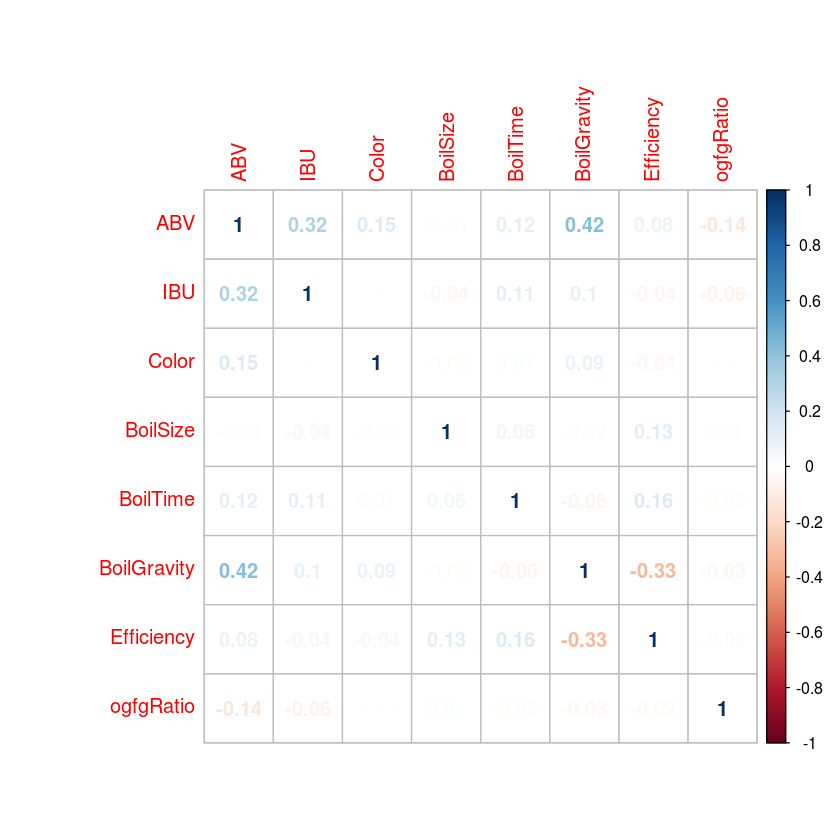

In [30]:
numericFeatScaled %>%
    mutate(ogfgRatio = OG/FG) %>%
    select(-OG, -FG) %>%
    cor(., use = "complete.obs") %>%
    corrplot(., method = "number")

Much better! 

### Discrete Variables

Let's take a look at the proportions of Brew Methods and Sugar Scales, our 2 categorical features, outside of our DV, Style.

In [31]:
categoryDF = recipeTopTen %>%
  select(which(sapply(., class) == "factor"))

colnames(categoryDF)

[1] "SugarScale" "Style"      "BrewMethod"

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

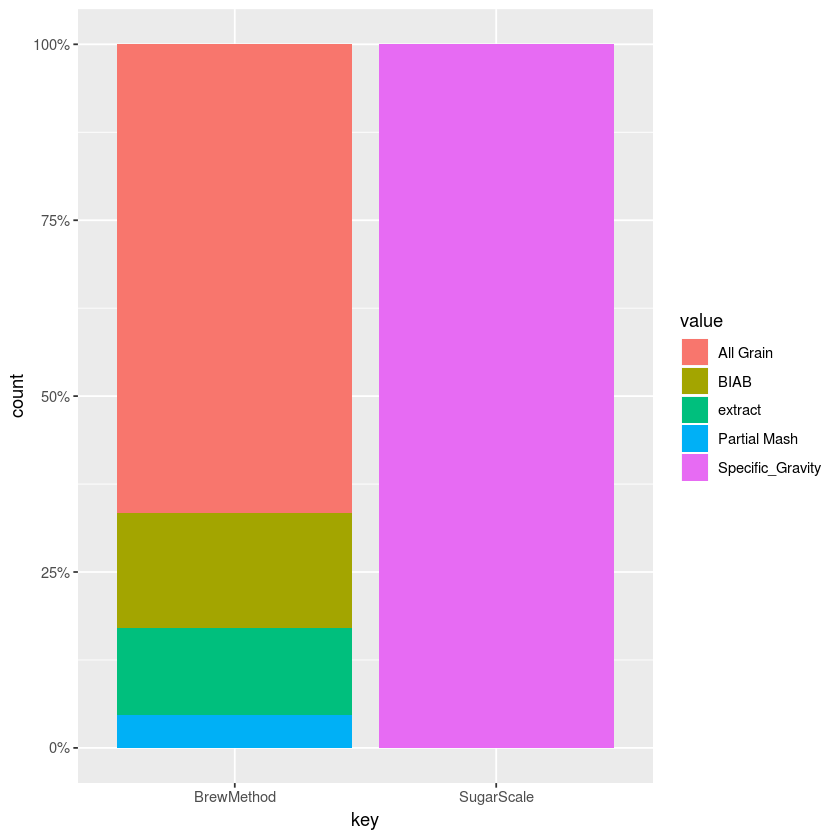

In [32]:
categoryDF %>%
    select(-Style) %>%
    gather("key", "value", SugarScale, BrewMethod) %>%
    ggplot(aes(x = key, fill = value)) +
    geom_bar(position = "fill") +
    scale_y_continuous(labels = scales::percent)

While I was imputing the missing values for BoilGravity, we came across how the column "SugarScale" was just information on if the values in OG, FG, and BoilGravity were recorded as Specific Gravity or Plato units. Now that everything has been converted to Specific Gravity, there is no variation in this column anymore, and can thus be removed.

In [33]:
categoryDF = categoryDF %>% select(-"SugarScale")
colnames(categoryDF)

[1] "Style"      "BrewMethod"

In [34]:
categoryDF %>%
    group_by(BrewMethod) %>%
    summarise(count = n(),
             percent = round(100*(count/nrow(categoryDF)), digits = 2))

BrewMethod,count,percent
All Grain,22190,66.62
BIAB,5463,16.40
extract,4106,12.33
Partial Mash,1549,4.65


Moving onto "BrewMethod", its also quite clear that "All Grain" is the majority (~66%). The rest of the feature account for the other 30%. I don't think it would hurt to leave this feature in the data set for now.

** A Quick Note: I thought about this when I was driving to soccer practice the other day, but it might be pretty interesting to see if the data can be grouped by "BrewMethod" and then using the data nested within each Brew Method come up with a model that can predict the style. I'm not the most knowledgeable person about beer, nor have I ever brewed any myself, but the Brew Method in my eyes seems like more of a process variable rather than a qualitative attribute of the beer style. For all beer experts out there, please shout at me if I am way off, or even if I may be partially right. Feedback is always appreciated and encouraged :-) **

#### Re-combine the numerical and categorical features into 1 dataset
Now that we have pre-processed and manipulated the data to a comfortable point, its time to stich the numerical and categorical features back together

In [35]:
recipeFeatures = numericFeatScaled %>%
    bind_cols(categoryDF)

head(recipeFeatures)

OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,Style,BrewMethod
0.2674656,1.02172146,-0.08969692,0.13240064,-0.1565012,-0.1452537,-0.3005794,-0.2185276,0.2796235,American IPA,extract
0.1240061,0.80281098,-0.16674288,0.02575939,-0.2114114,-0.1257000,-0.3005794,-0.2185276,0.2796235,American IPA,All Grain
-0.3063724,-0.07283096,-0.32083479,-0.29528219,-0.2686095,-0.1110476,0.5277991,-0.2185276,0.9155584,American Pale Ale,All Grain
0.9130334,1.02172146,0.73679607,4.81522581,-0.4596512,-0.1061978,2.1845562,-0.2185276,0.6329207,Imperial IPA,All Grain
1.4868714,0.80281098,1.52826817,0.88738492,-0.2354346,-0.1159489,-0.3005794,0.2391596,0.2796235,Imperial IPA,All Grain
0.3391954,0.14607953,0.41460389,0.24440749,-0.2937767,-0.1128017,2.1845562,0.1143359,0.5622612,American IPA,All Grain


In [36]:
# I could find a function for one-hot encoding for data frames that output a dataframe as well, so i made my own
one_hot = function(data, cols) {
    for(j in 1:length(cols)) {
        l = unique(data[,cols[j]])
        
        for(i in 1:length(l)) {
            c = data[,cols[j]]
            arr = if_else(c == l[i], 1, 0)
            data = data %>%
                mutate(new = arr)
            
            colnames(data)[which(colnames(data) == 'new')] = as.character(l[i])
        }
    }
    
    data = data %>%
        select(-c(cols))
    return(data)
}

recipeOneHot = one_hot(recipeFeatures, c("BrewMethod"))
head(recipeOneHot)



OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,Style,extract,All Grain,BIAB,Partial Mash
0.2674656,1.02172146,-0.08969692,0.13240064,-0.1565012,-0.1452537,-0.3005794,-0.2185276,0.2796235,American IPA,1,0,0,0
0.1240061,0.80281098,-0.16674288,0.02575939,-0.2114114,-0.1257000,-0.3005794,-0.2185276,0.2796235,American IPA,0,1,0,0
-0.3063724,-0.07283096,-0.32083479,-0.29528219,-0.2686095,-0.1110476,0.5277991,-0.2185276,0.9155584,American Pale Ale,0,1,0,0
0.9130334,1.02172146,0.73679607,4.81522581,-0.4596512,-0.1061978,2.1845562,-0.2185276,0.6329207,Imperial IPA,0,1,0,0
1.4868714,0.80281098,1.52826817,0.88738492,-0.2354346,-0.1159489,-0.3005794,0.2391596,0.2796235,Imperial IPA,0,1,0,0
0.3391954,0.14607953,0.41460389,0.24440749,-0.2937767,-0.1128017,2.1845562,0.1143359,0.5622612,American IPA,0,1,0,0


### Homogeneity
To get an idea of how the data can be purely split, we will use a decision tree to visualize the splits in data, and a random forest to validate the importance of the chosen features.

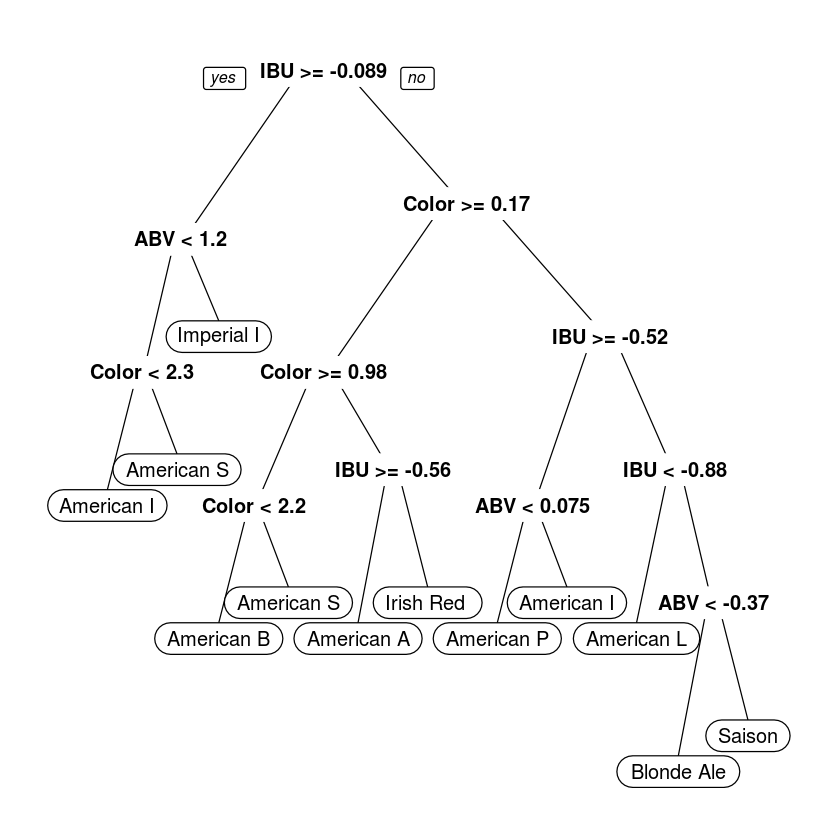

In [37]:
dtFit = rpart(Style ~ ., method = "class", data = recipeOneHot)
rpart.plot.version1(dtFit)

According to the decision tree, IBU, Color, and ABV seem to be the variables that help split the data up into its most homogenous forms, and in that particular order. Let's check the variable importance using the ensemble of the decision tree, randomforest.

In [40]:
colnames(recipeOneHot) = sapply(colnames(recipeOneHot), function(x) {
    if(grepl(" ", x)) {
        x = gsub(" ", "_", x)
        return(x)
    } else {
        return(x)
    }
})
head(recipeOneHot)

OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,Style,extract,All_Grain,BIAB,Partial_Mash
0.2674656,1.02172146,-0.08969692,0.13240064,-0.1565012,-0.1452537,-0.3005794,-0.2185276,0.2796235,American IPA,1,0,0,0
0.1240061,0.80281098,-0.16674288,0.02575939,-0.2114114,-0.1257000,-0.3005794,-0.2185276,0.2796235,American IPA,0,1,0,0
-0.3063724,-0.07283096,-0.32083479,-0.29528219,-0.2686095,-0.1110476,0.5277991,-0.2185276,0.9155584,American Pale Ale,0,1,0,0
0.9130334,1.02172146,0.73679607,4.81522581,-0.4596512,-0.1061978,2.1845562,-0.2185276,0.6329207,Imperial IPA,0,1,0,0
1.4868714,0.80281098,1.52826817,0.88738492,-0.2354346,-0.1159489,-0.3005794,0.2391596,0.2796235,Imperial IPA,0,1,0,0
0.3391954,0.14607953,0.41460389,0.24440749,-0.2937767,-0.1128017,2.1845562,0.1143359,0.5622612,American IPA,0,1,0,0


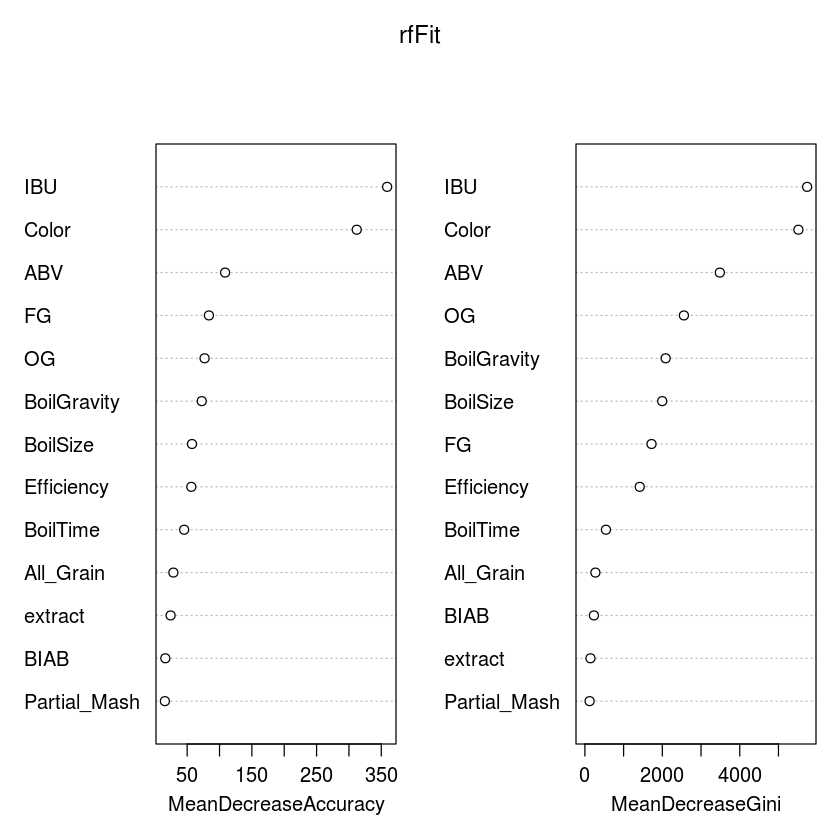

In [41]:
rfFit = randomForest(Style ~ ., data = recipeOneHot, importance = T)
varImpPlot(rfFit)

The randomforest further validates the splits made by the decision tree.

Finally, time to move on to modelling.

# Machine Learning
## Train & Test Data Split

I'll do a 70-30 split. (70% train, 30% test)

In [42]:
set.seed(0415)
trainIndecies = sample(seq_len(nrow(recipeOneHot)), size = round(nrow(recipeOneHot)*0.75, digits = 0))

train = recipeOneHot[trainIndecies,]
test = recipeOneHot[-trainIndecies, ]

## Train, Test, and Accuracy

The models that I'll try out are:
1. Decision Tree
  - Splits data into its most homogenous groups
  - Default is the greedy approach (chooses largest information gain at each step rather than choosing best option from a global perspective)
2. Random Forest
  - The ensembling method of Decision Trees
  - A collection of randomly sampled subset of features that compose multiple decision trees where all results are aggregated into one
3. Naive Bayes
  - Assumes independence among predictors (naivety)
  - No variance to minimize
4. Support Vector Machine
  - Creates linear hyperplanes that best separate the data into classes by maximizing the margins between the plane and the closest points of the data sets


### Train

In [43]:
decisionTreeFit = rpart(Style ~ ., data = train, method = "class")
randomForestFit = randomForest(Style ~ ., data = train) # !! for large datasets do not use the forumula interface
naiveBayesFit = naiveBayes(Style ~ ., data = train)
supportVectorMachineFit = svm(Style ~ ., data = train)

### Test

In [44]:
test$dtPred = predict(decisionTreeFit, test, type = "class")
test$rfPred = predict(randomForestFit, test, type = "class")
test$nbPred = predict(naiveBayesFit, test, type = "class")
test$svmPred = predict(supportVectorMachineFit, test, type = "class")

### Accuracy

In [45]:
dtTable = table(test$Style, test$dtPred)
rfTable = table(test$Style, test$rfPred)
nbTable = table(test$Style, test$nbPred)
svmTable = table(test$Style, test$svmPred)

accuracy = function(x) {
  round(sum(diag(x))/sum(x), digits = 2)
}

sapply(list(decisiontree = dtTable, randomforest = rfTable, naivebayes = nbTable, svm = svmTable), accuracy)

decisiontree randomforest   naivebayes          svm 
        0.59         0.63         0.49         0.60

Random Forest wins!

# Nested Modelling

Going back to an earlier hunch, I thought it would be interesting to see if the model performance would improve after grouping the data by "BrewMethod". I'll use the tidy and purrr packages to accomplish this. But before creating the train and test set, I have to undo the one-hot encoding I did since it was originally done on the "BrewMethod" column.

In [55]:
set.seed(0415)
trainIndecies = sample(seq_len(nrow(recipeFeatures)), size = round(nrow(recipeFeatures)*0.75, digits = 0))

train = recipeFeatures[trainIndecies,]
test = recipeFeatures[-trainIndecies, ]

recipeNest = train %>%
  nest(-BrewMethod) # Nests the data associated with the group (tidy package)

In [57]:
recipeLM = recipeNest %>%
  mutate(model = map(data, ~ randomForest(Style ~ ., data = ., method = "class"))) %>% # create a random forest model trained on each set of data specific to the BrewMethod group
  mutate(results = map(model, ~ predict(., test, type = "class"))) %>% # use each random forest model and test it
  mutate(scores = map(results, function(x) { # get the true positive rate
    confMat = table(x, test$Style)
    data.frame(accuracy = round(100*sum(diag(confMat))/sum(confMat), digits = 2))
  })) %>%
  mutate(amountData = map(data, nrow)) %>%
  select(BrewMethod, scores, amountData) %>%
  unnest()

recipeLM # show the grouped accuracies 

recipeLM %>%
  summarise(avgAccuracy = mean(accuracy)) # calculate the average accuracy between the models

BrewMethod,amountData,accuracy
All Grain,16622,62.90
extract,3068,58.82
BIAB,4109,60.13
Partial Mash,1182,57.98


avgAccuracy
59.9575


Interesting that all of the models performed relatively the same as the ungrouped model.

If you followed along, thanks! Any recommendations or suggestions or places where I made a mistake please let me know, it would be much appreciated! I learned A LOT about beer during this journey. I think I'll treat myself to a few tonight :-).